In [1]:
! pip install yfinance

You should consider upgrading via the 'C:\Users\Enrico\PycharmProjects\bfh-ai-1\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
from __future__ import print_function

import pandas as pd
import numpy as np
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
import os
import datetime
import time

import bs4 as bs
import numpy as np
import pandas as pd
import requests
import yfinance as yf
import torch.utils.data as data_utils



In [3]:
class MyDataset():

    def __init__(self, device='cpu', batch_size = 16):
        self.url = 'http://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
        self.stocks_fname = "sp500_closefull.csv"
        self.start = datetime.datetime(2010, 1, 1)
        self.stop = datetime.datetime.now()
        self.Ntest = 1000
        self.now = time.time()
        self.device = device
        self.batch_size = batch_size
       
    def get_loaders(self) -> pd.DataFrame:

        start = self.start  
        end = self.stop 

        if not os.path.isfile(self.stocks_fname):
          resp = requests.get(self.url)
          soup = bs.BeautifulSoup(resp.text, 'lxml')
          table = soup.find('table', {'class': 'wikitable sortable'})
          tickers = []

          for row in table.findAll('tr')[1:]:
              ticker = row.findAll('td')[0].text
              tickers.append(ticker)

          tickers = [s.replace('\n', '') for s in tickers]
          data = yf.download(tickers, start=start, end=end)
          data['Adj Close'].to_csv(self.stocks_fname)

        df0 = pd.read_csv(self.stocks_fname, index_col=0, parse_dates=True)

        df_spy = yf.download("SPY", start=start, end=end)

        df_spy = df_spy.loc[:, ['Adj Close']]

        df_spy.columns = ['SPY']
        
        df0 = pd.concat([df0, df_spy], axis=1)


        df0.dropna(axis=0, how='all', inplace=True)
        print("Dropping columns due to nans > 50%:", df0.loc[:, list((100 * (df0.isnull().sum() / len(df0.index)) > 50))].columns)
        df0 = df0.drop(df0.loc[:, list((100 * (df0.isnull().sum() / len(df0.index)) > 50))].columns, 1)
        df0 = df0.ffill().bfill()

        print("Any columns still contain nans:", df0.isnull().values.any())

        df_returns = pd.DataFrame()
        for name in df0.columns:
          df_returns[name] = np.log(df0[name]).diff()

        df_returns.dropna(axis=0, how='any', inplace=True)
        # Convert returns into 0/1 
        df_returns.SPY = [1 if spy > 0 else 0 for spy in df_returns.SPY]

        #  =====================================
        train_data = df_returns.iloc[:-self.Ntest]
        validate_data = df_returns.iloc[len(df_returns)-self.Ntest:(len(df_returns)) - int(self.Ntest/2)]
        test_data = df_returns.iloc[-int(self.Ntest/2):]

        # All data MUST BE FLOAT It´s due to PyTorch ! (no ints here, neither labels are ints)
        train_labels = torch.tensor(train_data.SPY.values).float().unsqueeze(1)
        train_features = torch.tensor(train_data.drop('SPY', axis=1).values).float()
        #
        validate_labels = torch.tensor(validate_data.SPY.values).float().unsqueeze(1)
        validate_features = torch.tensor(validate_data.drop('SPY', axis=1).values).float()
        #
        test_labels = torch.tensor(test_data.SPY.values).float().unsqueeze(1)
        test_features = torch.tensor(test_data.drop('SPY', axis=1).values).float()

        # ==============================
        training_data=data_utils.TensorDataset(train_features, train_labels)
       # training_data=data_utils.TensorDataset(train_features) 
        test_data=data_utils.TensorDataset(test_features, test_labels)              
        validate_data=data_utils.TensorDataset(validate_features, validate_labels)

        loaders = (data_utils.DataLoader(training_data, batch_size=self.batch_size),
                  data_utils.DataLoader(test_data, batch_size=self.batch_size),
                  data_utils.DataLoader(validate_data, batch_size=self.batch_size))

        return loaders

In [4]:
class VAE(nn.Module):
    def __init__(self, n_obs):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(n_obs, 400)
        self.fc21 = nn.Linear(400, 20) # mu 30
        self.fc22 = nn.Linear(400, 20) # log 30 variance
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, n_obs)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)

        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return self.fc4(h3) # torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, x.shape[1]))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [5]:
class Trainer():

    def __init__ (self):
        super(Trainer, self).__init__()

        cuda = torch.cuda.is_available()
        self.device = torch.device("cuda" if cuda else "cpu")

        torch.manual_seed(0)

        dataset = MyDataset()
        train_loader, test_loader, val_loader = dataset.get_loaders()

        self.train_loader = train_loader
        self.test_loader = test_loader
        self.size = train_loader.dataset.tensors[0].data.shape[1] # + 1

        self.model = VAE(self.size).to(self.device) # TO DO
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)

    def train(self, epoch):
        self.model.train()
        train_loss = 0
        for batch_idx, data in enumerate(self.train_loader):
            data = data[0].to(self.device)
            # torch.cat([data[0], ata[1]], dim=1)
            self.optimizer.zero_grad()
            recon_batch, mu, logvar = self.model(data)
            loss = self.loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            self.optimizer.step()
            if batch_idx % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(self.train_loader.dataset),
                           100. * batch_idx / len(self.train_loader),
                           loss.item() / len(data)))

        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(self.train_loader.dataset)))

    def save(self):
        path = './runs/{}/'.format('vae')
        try:
            os.makedirs(path)
        except:
            pass

        torch.save(self.model.state_dict(), os.path.join(path, 'vae_state_dict'))

    def test(self, epoch):
        self.model.eval()
        test_loss = 0
        with torch.no_grad():
            for i, data in enumerate(self.test_loader):
                data = data[0].to(self.device)
                recon_batch, mu, logvar = self.model(data)
                test_loss += self.loss_function(recon_batch, data, mu, logvar).item()

        test_loss /= len(self.test_loader.dataset)
        print('====> Test set loss: {:.4f}'.format(test_loss))

        # Reconstruction + KL divergence losses summed over all elements and batch

    def loss_function(self, recon_x, x, mu, logvar):
        MSE = F.mse_loss(recon_x, x.view(-1, self.size), reduction='mean')
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return MSE + KLD


In [6]:
trainer = Trainer()

for epoch in range(1, 10):
    trainer.train(epoch)
    trainer.test(epoch)
    #with torch.no_grad():
    #    sample = torch.randn(64, 20).to(trainer.device)
    #    sample = trainer.model.decode(sample).cpu()

trainer.save()


model = VAE(trainer.size)
model.load_state_dict(torch.load('./runs/vae/vae_state_dict'))

[*********************100%***********************]  505 of 505 completed

2 Failed downloads:
- BRK.B: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
Dropping columns due to nans > 50%: Index(['BF.B', 'BRK.B', 'CARR', 'CDAY', 'CTVA', 'DOW', 'FOX', 'FOXA', 'FTV',
       'HWM', 'IR', 'LW', 'MRNA', 'OGN', 'OTIS', 'UA'],
      dtype='object')
Any columns still contain nans: False


C:\Users\Enrico\AppData\Local\Temp/ipykernel_9436/2557366169.py:45: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df0 = df0.drop(df0.loc[:, list((100 * (df0.isnull().sum() / len(df0.index)) > 50))].columns, 1)
C:\Users\Enrico\AppData\Local\Temp/ipykernel_9436/2557366169.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_returns[name] = np.log(df0[name]).diff()


Train Epoch: 1 [0/2003 (0%)]	Loss: 0.012110
Train Epoch: 1 [160/2003 (8%)]	Loss: 0.002004
Train Epoch: 1 [320/2003 (16%)]	Loss: 0.001000
Train Epoch: 1 [480/2003 (24%)]	Loss: 0.000964
Train Epoch: 1 [640/2003 (32%)]	Loss: 0.000706
Train Epoch: 1 [800/2003 (40%)]	Loss: 0.000503
Train Epoch: 1 [960/2003 (48%)]	Loss: 0.000547
Train Epoch: 1 [1120/2003 (56%)]	Loss: 0.000399
Train Epoch: 1 [1280/2003 (63%)]	Loss: 0.000407
Train Epoch: 1 [1440/2003 (71%)]	Loss: 0.000343
Train Epoch: 1 [1600/2003 (79%)]	Loss: 0.000327
Train Epoch: 1 [1760/2003 (87%)]	Loss: 0.000342
Train Epoch: 1 [1920/2003 (95%)]	Loss: 0.000273
====> Epoch: 1 Average loss: 0.0009
====> Test set loss: 0.0005
Train Epoch: 2 [0/2003 (0%)]	Loss: 0.000287
Train Epoch: 2 [160/2003 (8%)]	Loss: 0.000264
Train Epoch: 2 [320/2003 (16%)]	Loss: 0.000216
Train Epoch: 2 [480/2003 (24%)]	Loss: 0.000298
Train Epoch: 2 [640/2003 (32%)]	Loss: 0.000259
Train Epoch: 2 [800/2003 (40%)]	Loss: 0.000176
Train Epoch: 2 [960/2003 (48%)]	Loss: 0.00015

<All keys matched successfully>

In [7]:
dataset = MyDataset()
train_loader, test_loader, val_loader = dataset.get_loaders()



[*********************100%***********************]  1 of 1 completed
Dropping columns due to nans > 50%: Index(['BF.B', 'BRK.B', 'CARR', 'CDAY', 'CTVA', 'DOW', 'FOX', 'FOXA', 'FTV',
       'HWM', 'IR', 'LW', 'MRNA', 'OGN', 'OTIS', 'UA'],
      dtype='object')
Any columns still contain nans: False


C:\Users\Enrico\AppData\Local\Temp/ipykernel_9436/2557366169.py:45: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df0 = df0.drop(df0.loc[:, list((100 * (df0.isnull().sum() / len(df0.index)) > 50))].columns, 1)
C:\Users\Enrico\AppData\Local\Temp/ipykernel_9436/2557366169.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_returns[name] = np.log(df0[name]).diff()


In [8]:
samples = []
for i in range(100):
  with torch.no_grad():
    sample_feat, _, _ = model(train_loader.dataset.tensors[0])
    sample_labels = train_loader.dataset.tensors[1]
    new_data_sample = torch.cat([sample_feat, sample_labels], dim=1)
    samples.append(new_data_sample.numpy())

In [9]:
generated_np = np.vstack(samples)

In [10]:
pd.DataFrame(generated_np)

,0,1,2,3,4,5,6,7,8,9,...,480,481,482,483,484,485,486,487,488,489
0,-0.013309,0.006468,-0.016548,-0.004692,-0.005061,-0.011828,-0.038937,0.006759,0.003961,-0.002288,...,-0.015458,0.000598,-0.000235,0.008924,-0.007797,-0.007581,-0.006970,0.011148,0.001282,1.0
1,0.016283,-0.002151,0.015380,0.009681,0.012842,-0.008967,-0.020620,0.000925,-0.008225,-0.025962,...,-0.020223,-0.003092,-0.001582,0.000382,0.032076,0.016903,0.003369,-0.003339,0.016659,1.0
2,0.009759,-0.003754,-0.004415,0.008300,-0.001252,0.004384,0.019321,0.016837,-0.000067,0.012418,...,-0.006401,-0.001721,0.009147,-0.009129,-0.001653,-0.003361,0.007884,-0.004585,-0.006246,1.0
3,-0.006915,0.010222,0.007732,-0.010067,-0.008446,0.013064,0.004086,-0.006125,-0.007665,0.021221,...,-0.007438,-0.000602,0.001958,0.005204,-0.003383,-0.004886,0.014769,0.002048,-0.010223,1.0
4,-0.011476,0.006925,0.022603,0.008090,-0.009121,0.011034,-0.010549,-0.000805,0.023425,-0.004668,...,-0.005862,-0.016582,0.012860,0.009485,-0.004107,0.005359,0.015466,0.009795,-0.002793,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200295,-0.003041,0.004826,-0.005480,0.002388,0.015091,0.005148,0.014368,0.026845,0.001434,-0.007512,...,-0.011889,-0.003600,0.021180,-0.004672,-0.018881,0.001888,-0.008226,0.000379,-0.004198,1.0
200296,-0.002637,0.011397,0.015422,-0.007600,-0.015726,0.010198,0.007674,-0.007203,-0.009693,-0.008614,...,-0.015963,-0.026769,-0.013414,-0.004623,0.002439,0.010378,0.005766,-0.021179,0.002891,1.0
200297,0.001978,0.030882,-0.003870,0.010084,-0.006669,0.000498,-0.036927,-0.001812,-0.012003,0.005345,...,-0.001676,-0.013348,-0.000505,-0.004418,0.008398,0.021120,-0.007946,-0.006016,0.003147,1.0
200298,-0.008877,0.007934,0.010276,-0.009344,-0.002490,0.014135,0.001304,-0.016034,-0.010241,-0.008443,...,-0.006603,0.005039,-0.017867,0.003022,0.004023,-0.014954,0.007010,0.009864,-0.006455,0.0


In [11]:
orig = train_loader.dataset.tensors[0].detach().numpy()[0, :]
gen = generated_np[0, :-1]

In [12]:
import matplotlib.pyplot as plt

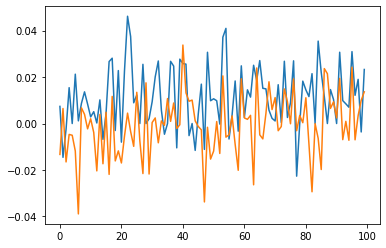

In [13]:
plt.plot(orig[:100])
plt.plot(gen[:100])

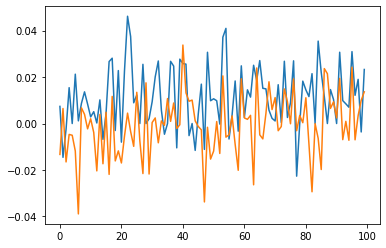

In [14]:
plt.plot(orig[:100])
plt.plot(gen[:100])

In [15]:
generated_np.shape

(200300, 490)

In [16]:
# np.int()
# tttt.int()
# 